In [7]:
import pandas as pd
import json
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [15]:
############# Preprocessing sets
cancer = 'BRCA'
ft_file = '../data/correlation/CORR_' + cancer + '_featurelist.tsv'
master_file = '../src/tarball/' + cancer + '_v8_20200203.tsv'
outdir = '../data/correlation/out/'
#############

############# Correlation sets
# Options 'gnosis:BRCA:1', 
#         'BRCA:CF|All_Top 100',
#         'AKLIMATE_BRCA_reduced_model_1000_feature_set',
#         'nn_jg_2020-03-20_top1kfreq:BRCA', 
#         'fbedeBIC_BRCA'
grp1 = 'gnosis:BRCA:1'
grp2 = 'BRCA:CF|All_Top 100'
grp1_label='gnosis'
grp2_label='cloudforest'
cancer = 'BRCA'
#############

# Correlation Analysis

In [9]:
# Features for each model
ft_df = pd.read_csv(ft_file, sep = '\t')

# Raw tarball - samples x [labels, feature values]
master_df = pd.read_csv(master_file, sep='\t', index_col=0)

How much overlap?

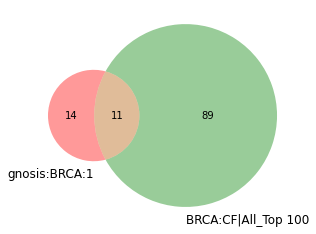

In [17]:
# save venn diagram
venn2([set(ft_df[grp1].dropna()), set(ft_df[grp2].dropna())], set_labels=[grp1,grp2])
plt.savefig('../data/correlation_exact_match/venn_{}_{}.png'.format(grp1_label, grp2_label) )

Of those not overlapping, are they correlated?

In [18]:
# Get feature lists
grp1_fts = ft_df[grp1].dropna()
grp2_fts = ft_df[grp2].dropna()

# Dataframe prep
cols = ['corr', 'pval', 'gene1', 'gene2', 'group1', 'group2']
gene1 = []
gene2 = []
corr = []
pval = []
group1 = []
group2 = []
    
# calculate corr
for g1 in grp1_fts:
    for g2 in grp2_fts:
#         if 'GEXP' in g1 and 'GEXP' in g2:
        if g1 == g2:
            pass
        else:
            # correlation matrix (coor coefficients)
            x = master_df[g1]
            y = master_df[g2]
            c, p = scipy.stats.spearmanr(x, y)

            gene1.append(g1)
            gene2.append(g2)
            corr.append(c)
            pval.append(p)
            group1.append(grp1)
            group2.append(grp2)

# save correlation result values
res = pd.DataFrame(list(zip( corr, pval,gene1, gene2, group1, group2)), columns = cols)
res = res.reindex(res['corr'].abs().sort_values(ascending=False).index).reset_index(drop=True) # sort by abs corr
res.to_csv(outdir + 'corr_matrix_' + grp1 + '_' + grp2 + '.tsv', sep='\t',index=False)
res

,corr,pval,gene1,gene2,group1,group2
0,0.911333,0.000000,N:GEXP::TPX2:22974:,N:GEXP::CCNA2:890:,gnosis:BRCA:1,BRCA:CF|All_Top 100
1,0.910782,0.000000,N:GEXP::TPX2:22974:,N:GEXP::BUB1:699:,gnosis:BRCA:1,BRCA:CF|All_Top 100
2,0.909773,0.000000,N:GEXP::CENPA:1058:,N:GEXP::CCNB2:9133:,gnosis:BRCA:1,BRCA:CF|All_Top 100
3,0.907859,0.000000,N:GEXP::TPX2:22974:,N:GEXP::CEP55:55165:,gnosis:BRCA:1,BRCA:CF|All_Top 100
4,0.905904,0.000000,N:GEXP::TPX2:22974:,N:GEXP::FOXM1:2305:,gnosis:BRCA:1,BRCA:CF|All_Top 100
...,...,...,...,...,...,...
2484,-0.001139,0.971366,N:GEXP::DEGS2:123099:,N:GEXP::CLCA2:9635:,gnosis:BRCA:1,BRCA:CF|All_Top 100
2485,0.000971,0.975606,N:GEXP::WDR67:93594:,N:GEXP::TRIM29:23650:,gnosis:BRCA:1,BRCA:CF|All_Top 100
2486,0.000811,0.979617,N:MIR::hsa-miR-30c-2-3p:Corrected:,N:GEXP::BCL11A:53335:,gnosis:BRCA:1,BRCA:CF|All_Top 100
2487,0.000615,0.984542,N:MIR::hsa-miR-4677-3p:Corrected:,N:GEXP::GRB7:2886:,gnosis:BRCA:1,BRCA:CF|All_Top 100


In [32]:
# write log file
with open('../data/correlation_exact_match/log_{}_{}.txt'.format(grp1_label, grp2_label), 'w') as out:
    n_correlated = len(res[res['corr']> 0.5]) + len(res[res['corr']< -0.5])
    out.write(' '.join(['#', grp1, grp2]) + '\n')
    out.write(str(n_correlated) + ' correlated genes pairs (' + str((n_correlated/res.shape[0] )*100) + '%)\n')
    out.write('excludes instances where both groups picked same gene\n')

##### Log (stored in `data/correlation/out/` with prefix `corr_matrix_`)

Between JADBIO and CloudForest (gnosis:BRCA:1, BRCA:CF|All_Top 100)
+ 11 overlaps
+ 560 correlated genes pairs ( 22.49899558055444 %) excludes instances where both groups picked same gene. 

Between JADBIO and AKLIMATE (gnosis:BRCA:1, AKLIMATE_BRCA_reduced_model_1000_feature_set)
+ 22 overlaps
+ 5295 correlated genes pairs ( 7.908532851403223 %) excludes instances where both groups picked same gene


Between JADBIO and SubSCOPE (gnosis:BRCA:1, nn_jg_2020-03-20_top1kfreq:BRCA)
+ 2 overlaps
+ 432 correlated genes pairs ( 2.179286687181557 %) excludes instances where both groups picked same gene


Between JADBIO and SciKit_grid
+ 
+ 



Between CloudForest and AKLIMATE (AKLIMATE_BRCA_reduced_model_1000_feature_set, BRCA:CF|All_Top 100)
+ 96 overlaps
+ 19652 correlated genes pairs ( 7.338202566055772 %) excludes instances where both groups picked same gene

Between CloudForest and SubSCOPE (BRCA:CF|All_Top 100, nn_jg_2020-03-20_top1kfreq:BRCA)
+ 5 overlaps
+ 1550 correlated genes pairs ( 1.954726023078378 %) excludes instances where both groups picked same gene

Between CloudForest and SciKit_grid
+ 
+ 

Between AKLIMATE and SubSCOPE
+ 239 overlaps
+ 

Between AKLIMATE and SciKit_grid
+ 
+ 

Between SubSCOPE and SciKit_grid
+ 
+ 

# Suggestions

In [ ]:
# then is this number more or less than we expect randomly -- we can do a null model
# what if those 2 groups picked randomly any genes (from orig matix) > until fill
# then repeat 100 times (check for more correlations, but could do 2 tailed )
# ---eventually play with pval thres
# then plot distribut of this null model

In [ ]:
# explore miRNA
res_dict = {}

for col in ft_df.columns:
    vals = []
    for f in ft_df[col].dropna():
        if 'N:MIR' in f:
            vals.append(f)
    res_dict[col]=vals


In [ ]:
mi_df = pd.DataFrame.from_dict(res_dict,orient='index').T
print('these are the miRNA features in the best performing models')
mi_df